In [ ]:
# import BCI_analysis, os

local_temp_dir = '/home/jupyter/temp/' 
metadata_dir = '/home/jupyter/bucket/Metadata/' 
raw_scanimage_dir_base ='/home/jupyter/bucket/Data/Calcium_imaging/raw/' 
suite2p_dir_base = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/'
setup = 'Bergamo-2P-Photostim'#'DOM3-MMIMS'
save_path = "/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba"
fov = 'FOV_01'
subject = 'PKJ_01'
BCI_analysis.io_suite2p.suite2p_to_npy(os.path.join(suite2p_dir_base,setup), 
                                       os.path.join(raw_scanimage_dir_base,setup), 
                                       os.path.join(bpod_path,setup),
                                       save_path, 
                                       overwrite=False, 
                                       mice_name = subject,
                                       fov_list = [fov],
                                       max_frames = 500)

NameError: name 'BCI_analysis' is not defined

In [17]:
# bpod_zaber_data = np.load('/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/PKJ_01/042423-bpod_zaber.npy', allow_pickle=True).tolist()

In [10]:
import numpy as np
import BCI_analysis
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def Gauss(x, A, B,C): # function for estimating the Z offset
    y = A*np.exp(-1*B*(x+C)**2)
    return y

use_scalar_f0 = False

sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
s2p_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim'
fov = 'FOV_02'
subject = 'PKJ_01'
add_shifts = True

files = os.listdir(os.path.join(sessionwise_base_dir,subject))
stat = np.load(os.path.join(s2p_base_dir,subject,fov,'stat.npy'),allow_pickle=True).tolist()
#stat_rest = np.load(os.path.join(s2p_base_dir,subject,fov,'stat_rest.npy'),allow_pickle=True).tolist()
sessions = []
data_dict = {}

for file in files[-5:]: ### NOT ALL FILES?? - 
    if fov in file:
        session = file[len(subject)+1:-1*(len(fov)+5)]
        sessions.append(session)
        data_dict[session] = BCI_analysis.io_python.read_sessionwise_npy(os.path.join(sessionwise_base_dir,subject,file))
        #data_dict[session] = np.load(os.path.join(sessionwise_base_dir,subject,file),allow_pickle = True).tolist()
        F0 = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F0.npy'))
        if add_shifts:
            ops =  np.load(os.path.join(s2p_base_dir,subject,fov,session, "ops.npy") ,allow_pickle = True).tolist()
            data_dict[session]['rigid_y_offset'] = ops['yoff_list']
            data_dict[session]['rigid_x_offset'] = ops['xoff_list']
            #data_dict[session]['nonrigid_y_offset'] = ops['yoff1_list']
            #data_dict[session]['nonrigid_x_offset'] = ops['xoff1_list']
            data_dict[session]['z_matrix'] = np.load(os.path.join(s2p_base_dir,subject,fov,session,'zcorr.npy'))
            
            parameter_list = []
            error_list = []
            xdata = np.arange(data_dict[session]['z_matrix'].shape[0])-data_dict[session]['z_matrix'].shape[0]/2
            for ydata in data_dict[session]['z_matrix'].T:
                ydata = ydata.flatten()#data_dict[session]['z_matrix'][:,120].flatten()
                try:
                    parameters, covariance = curve_fit(Gauss, xdata, ydata)
                except:
                    parameters = [np.nan]*3

                fit_y = Gauss(xdata, parameters[0], parameters[1],parameters[2])
                error_list.append(np.sum(np.abs(ydata-fit_y)))
                parameter_list.append(parameters)
            data_dict[session]['rigid_z_offset_raw'] = np.argmax(data_dict[session]['z_matrix'],0)-data_dict[session]['z_matrix'].shape[0]/2
            data_dict[session]['rigid_z_offset_fit'] = np.asarray(parameter_list)[:,2]*-1
        #asdas
        data_dict[session]['F0'] = F0
        if use_scalar_f0:
            data_dict[session]['dff_sessionwise'] = (data_dict[session]['F_sessionwise']-data_dict[session]['f0_scalar'][:,np.newaxis])/data_dict[session]['f0_scalar'][:,np.newaxis]
        #data_dict[session]['photon_counts']=np.load(os.path.join(s2p_base_dir,subject,fov,session,'photon_counts.npy'),allow_pickle=True).tolist()
        data_dict[session]['signal_to_noise_trace'] = data_dict[session]['dff_sessionwise']*data_dict[session]['photon_counts']['dprime_1dFF'][:,np.newaxis]
        reward_collecting_lick_times = []
        for reward_t,lick_t in zip(data_dict[session]['reward_times'],data_dict[session]['lick_times']):
            if len(reward_t) == 0:
                reward_collecting_lick_times.append(np.asarray([]))
            else:
                
                if any(lick_t>reward_t):
                    reward_collecting_lick_times.append(np.asarray([lick_t[np.argmax(lick_t>reward_t)]]))
                else:
                    reward_collecting_lick_times.append(np.asarray([]))
        data_dict[session]['reward_collecting_lick_times'] = np.asarray(reward_collecting_lick_times)
        # data_dict[session]['closed_loop_filenames'] = []
        # for fn in data_dict[session]['all_si_filenames']:
        #     if 'conditioning' in fn:
        #         data_dict[session]['closed_loop_filenames'].append(fn)
        print(file)

/tmp/ipykernel_20343/1458308275.py:9: RuntimeWarning: overflow encountered in exp
  y = A*np.exp(-1*B*(x+C)**2)


PKJ_01-050923-FOV_02.npy
PKJ_01-051023-FOV_02.npy


In [6]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)


In [491]:
m

'rigid_z_offset_fit'

Text(0, 0.5, 'Trial#')

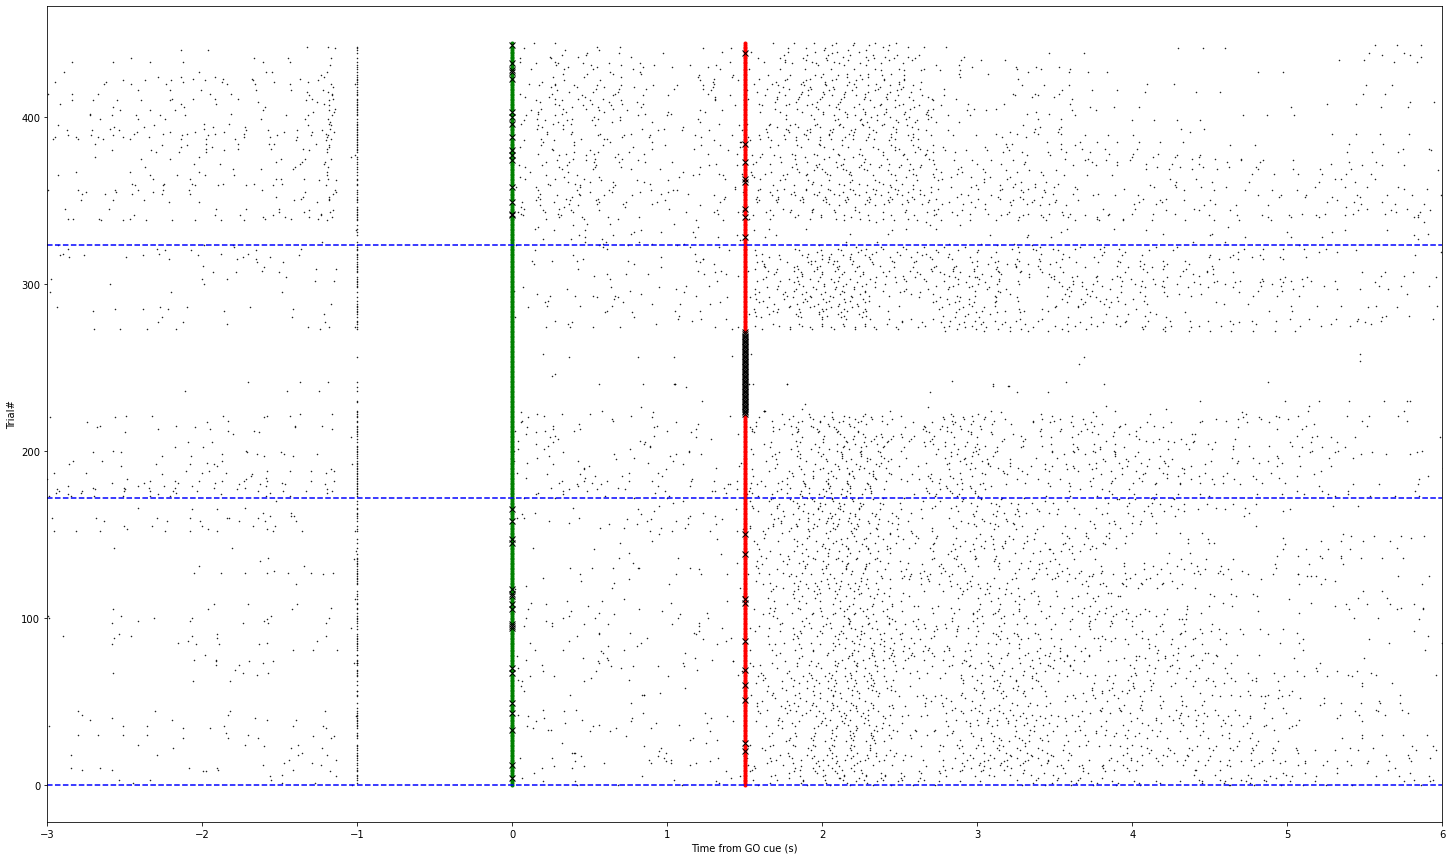

In [4]:
fig = plt.figure(figsize = [25,15])
ax1 = fig.add_subplot(1,1,1)
go_trial = []
go_t = []
go_omission_trial = []
go_omission_t = []
reward_trial = []
reward_t = []
reward_omission_trial = []
reward_omission_t = []
licks_t = []
licks_trial = []
new_session_trial = []
trial = 0
for session in sessions:
    new_session_trial.append(trial)
    for licks,rewards,gocues in zip(data_dict[session]['lick_times'],data_dict[session]['reward_times'],data_dict[session]['go_cue_times']):
        if len(rewards)>0 and gocues>0:
            go_reward_diff = rewards[0] - gocues
        if not gocues>0:
            go_omission_trial.append(trial)
            go_omission_t.append(0)
            gocues = rewards[0]-go_reward_diff
        else:
            go_trial.append(trial)
            go_t.append(0)
        if len(rewards)>0:
            reward_t.append(rewards[0]-gocues)
            reward_trial.append(trial)
        else:
            reward_omission_t.append(go_reward_diff)
            reward_omission_trial.append(trial)
        if len(licks)>0:
            licks_t.append(licks-gocues)
            licks_trial.append(np.ones(len(licks))*trial)
        trial+=1


ax1.plot(np.concatenate(licks_t),np.concatenate(licks_trial),'k.',markersize = 1)
ax1.plot(go_t,go_trial,'g.')
ax1.plot(go_omission_t,go_omission_trial,'kx')
ax1.plot(reward_t,reward_trial,'r.')
ax1.plot(reward_omission_t,reward_omission_trial,'kx')

ax1.set_xlim([-3,6])

ax1.hlines(new_session_trial,-3,6,colors='b', linestyles='dashed')
ax1.set_xlabel('Time from GO cue (s)')
ax1.set_ylabel('Trial#')

In [165]:
len(sessions)

6

nmin 20
0.07248497009277344
2.2681970596313477
2.320840358734131
2.322011947631836
(80, 100)
(32,)
1.0
time; iteration;  explained PC variance
0.49s     0        0.2973      8
0.54s    10        0.8085      48
0.59s    20        0.8724      80
0.63s    30        0.8723      80
0.64s   final      0.8723
1.83s upsampled    0.8723


Text(0.5, 1.0, 'PKJ_01_042723')

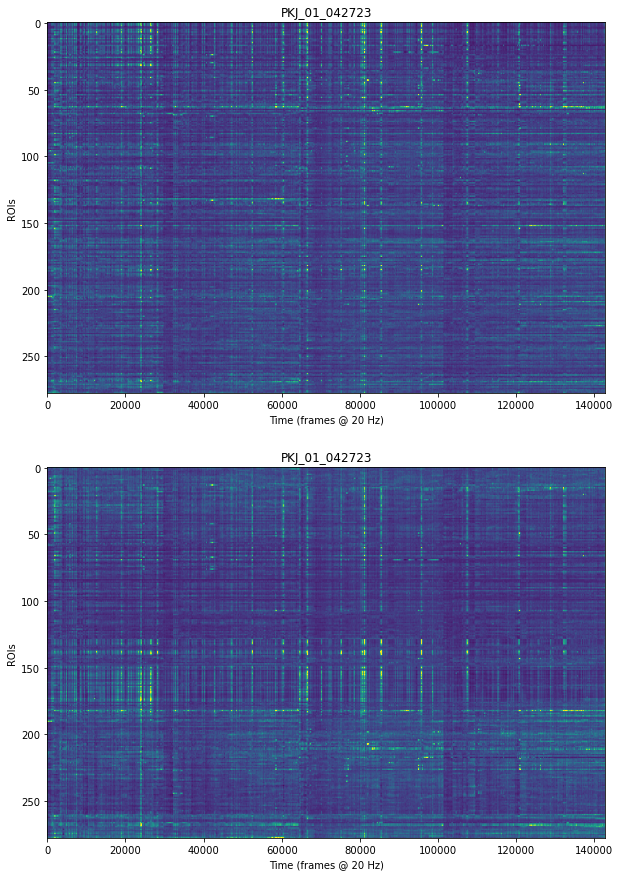

In [3]:
import matplotlib.pyplot as plt
from rastermap import Rastermap


minimum_f0 = 2#5 for pkj02#2 for pkj01
max_dff = 200 #20 for pkj02 #200 for pkj01
min_pixel_num = 40
max_session_num  = 4 #for pkj02# 4 for pkj01


pixnum_list = []
for s in stat:
    pixnum_list.append(s['npix'])
pixnum_list = np.asarray(pixnum_list)

dff_big = []
f0_big = []
for session in sessions[:max_session_num]:
    dff_big.append(data_dict[session]['dff_sessionwise'])
    f0_big.append(data_dict[session]['F0'])
dff_big = np.concatenate(dff_big,1)
f0_big = np.concatenate(f0_big,1)

needed_rois = (np.mean(f0_big,1)>=minimum_f0) & (np.any(np.isnan(dff_big),1) == False) &  (np.max(dff_big, 1)<=max_dff) & (pixnum_list>min_pixel_num)

dff_big = dff_big[needed_rois,:] #
needed_timepoints = np.max(dff_big,0)<max_dff/2
dff_big = dff_big[:,needed_timepoints] 


dff_now = data_dict[session]['dff_sessionwise'][needed_rois,:]
pixnum_list = pixnum_list[needed_rois]
stat_now = np.asarray(stat)[needed_rois]
model = Rastermap(n_components=2, n_X=10, nPC=20, init='pca')
model.fit(dff_big)


fig = plt.figure(figsize = [10,15])
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
im = ax1.imshow(dff_big,aspect='auto')
im.set_clim([-.1,10])
ax1.set_xlabel('Time (frames @ 20 Hz)')
ax1.set_ylabel('ROIs')
im = ax2.imshow(dff_big[model.isort, :],aspect = 'auto')
im.set_clim([-.1,10])
ax1.set_title('{}_{}'.format(data_dict[session]['mouse'],session))
#ax2.hlines(group_edges,0,dff_now.shape[1]-1,'red')
ax2.set_xlabel('Time (frames @ 20 Hz)')
ax2.set_ylabel('ROIs')
ax2.set_title('{}_{}'.format(data_dict[session]['mouse'],session))



In [205]:
data_dict[session].keys()

dict_keys(['file_path', 'file_name', 'subject', 'F_sessionwise', 'F_trialwise_all', 'F_trialwise_closed_loop', 'dff_sessionwise', 'dff_trialwise_all', 'dff_trialwise_closed_loop', 'cn', 'roiX', 'roiY', 'dist', 'FOV', 'session_date', 'session_path', 'mouse', 'mean_image', 'max_image', 'time_since_trial_start', 'go_cue_times', 'lick_times', 'reward_times', 'trial_times', 'hit', 'threshold_crossing_times', 'zaber_move_forward', 'sampling_rate', 'all_si_filenames', 'closed_loop_filenames', 'all_si_frame_nums', 'scanimage_filenames', 'photon_counts', 'f0_scalar', 'F0', 'signal_to_noise_trace', 'reward_collecting_lick_times'])

Text(0.5, 0, 'UMAP2')

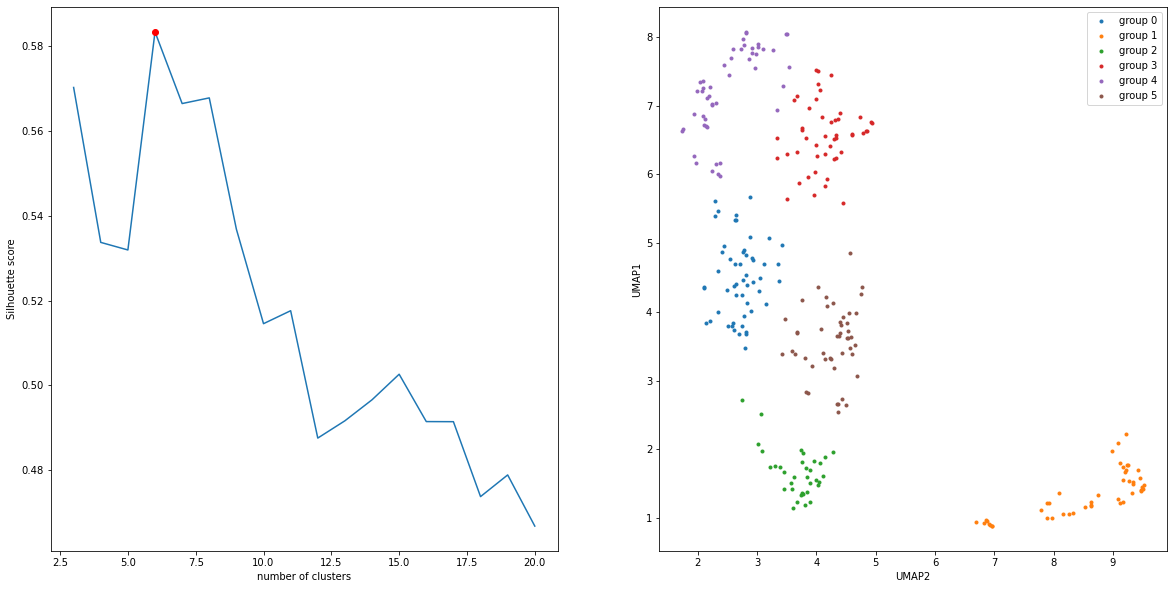

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import umap
reducer = umap.UMAP()

sil = []
kmax = 20


reducer.n_neighbors=4#4 - for both
reducer.min_dist = 0 # 0 for both
umap_embedding = reducer.fit_transform(dff_big)

coordinates = umap_embedding


# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
ks = list(range(3, kmax+1))
for k in ks:
  kmeans = KMeans(n_clusters = k).fit(coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(coordinates, labels, metric = 'euclidean'))

optimal_k_idx = np.argmax(sil)
optimal_k = ks[optimal_k_idx]
#optimal_k = 6
kmeans = KMeans(n_clusters = optimal_k).fit(coordinates)

fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(ks,sil)
ax1.plot(ks[optimal_k_idx],sil[optimal_k_idx],'ro')
for cluster_i in range(optimal_k):
    indices =kmeans.labels_ == cluster_i 
    ax2.plot(coordinates[indices,0],coordinates[indices,1],'.',label = 'group {}'.format(cluster_i))
ax2.legend()
ax1.set_ylabel('Silhouette score')
ax1.set_xlabel('number of clusters')

cell_group_identities = kmeans.labels_
ax2.set_ylabel('UMAP1')
ax2.set_xlabel('UMAP2')





Text(0.5, 1.0, 'Cross_correlation')

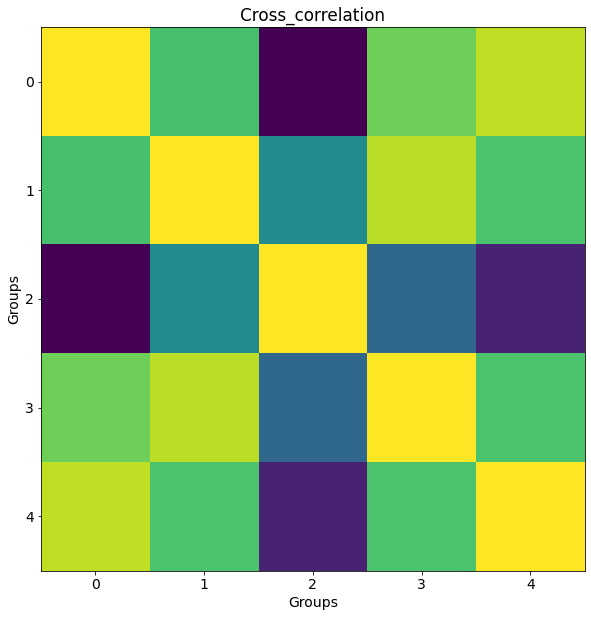

In [207]:
import scipy

mean_group_traces = []
for group_i in range(optimal_k):
    indices =kmeans.labels_ == group_i 
    mean_group_traces.append(np.nanmean(dff_big[indices,:],0))

cross_corr_matrix = np.zeros([optimal_k]*2)
for i,trace1 in enumerate(mean_group_traces):
    for ii,trace2 in enumerate(mean_group_traces):
        cross_corr_matrix[i,ii], pearsons_p = scipy.stats.pearsonr(trace1,trace2)
#group_edges = [0,55,99,115,134,146]

fig = plt.figure(figsize  = [10,10])
ax_corr_matrix = fig.add_subplot(1,1,1)
ax_corr_matrix.imshow(cross_corr_matrix)
#ax_corr_matrix.vlines(group_edges,0,cross_corr_matrix.shape[0]-1,'red')
#ax_corr_matrix.hlines(group_edges,0,cross_corr_matrix.shape[0]-1,'red')
ax_corr_matrix.set_xlabel('Groups')
ax_corr_matrix.set_ylabel('Groups')
ax_corr_matrix.set_title('Cross_correlation')


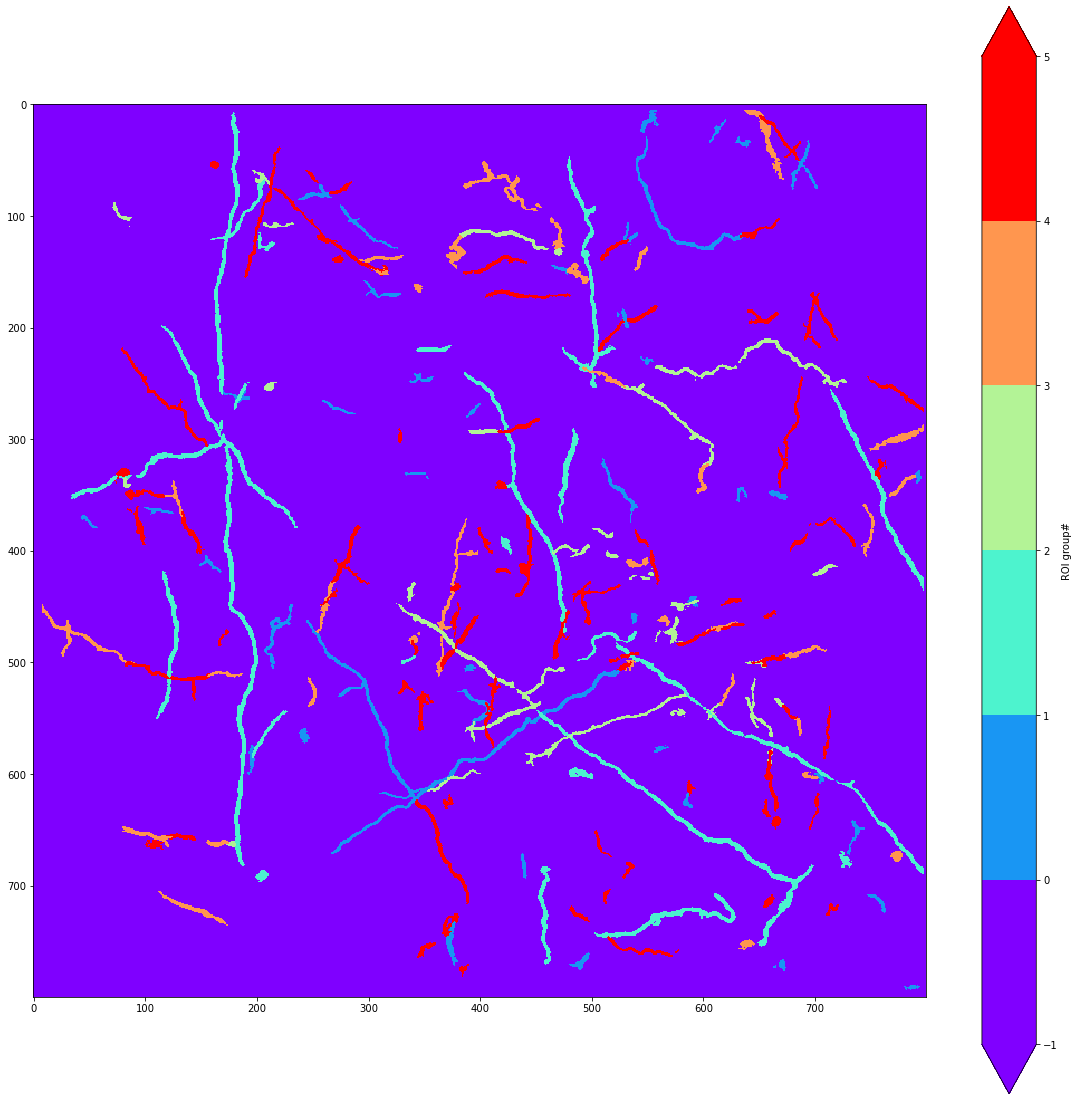

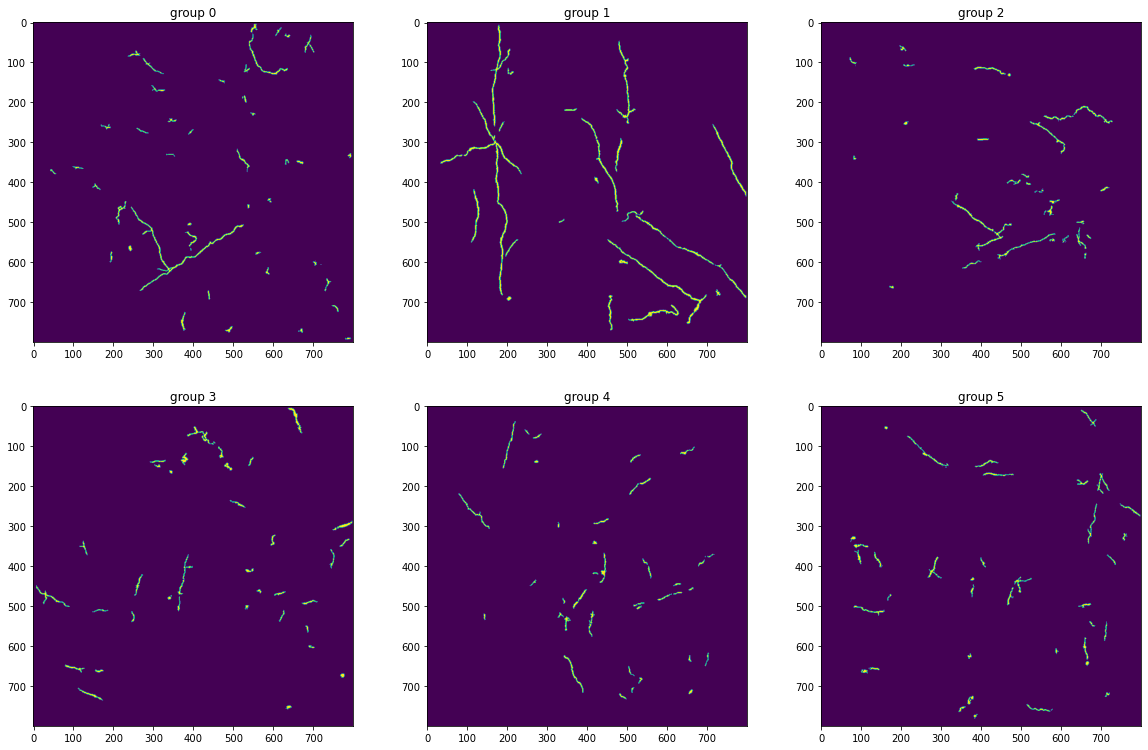

In [5]:
ROI_image = np.zeros_like(data_dict[session]['mean_image'])-1
ROI_image_list = []
for group_i in np.arange(optimal_k):
    ROI_image_list.append(np.zeros_like(data_dict[session]['mean_image'])-1)
    #cell_indices_needed = model.isort[group_start_idx:group_end_idx]
    cell_indices_needed = np.where(kmeans.labels_ == group_i )[0]
    for idx in cell_indices_needed:
        roi_stat = stat_now[idx]
        ROI_image[roi_stat['ypix'],roi_stat['xpix']] = group_i  
        ROI_image_list[group_i][roi_stat['ypix'],roi_stat['xpix']] = group_i  
from matplotlib import cm
cmap = cm.get_cmap('rainbow', 6)
fig = plt.figure(figsize  = [20,20])
ax= fig.add_subplot(1,1,1)
im = ax.imshow(ROI_image,cmap = cmap,interpolation = 'none')
cbar = fig.colorbar(im, ax=ax, extend='both')
cbar.set_label('ROI group#')
fig = plt.figure(figsize = [20,20])
rownum = int(np.round(np.sqrt(optimal_k)))+1
for i in range(optimal_k):
    ax = fig.add_subplot(rownum,rownum,i+1)
    ax.imshow(ROI_image_list[i])
    ax.set_title('group {}'.format(i))

In [209]:
session

'050223'

Text(0.5, 0, 'Time (s)')

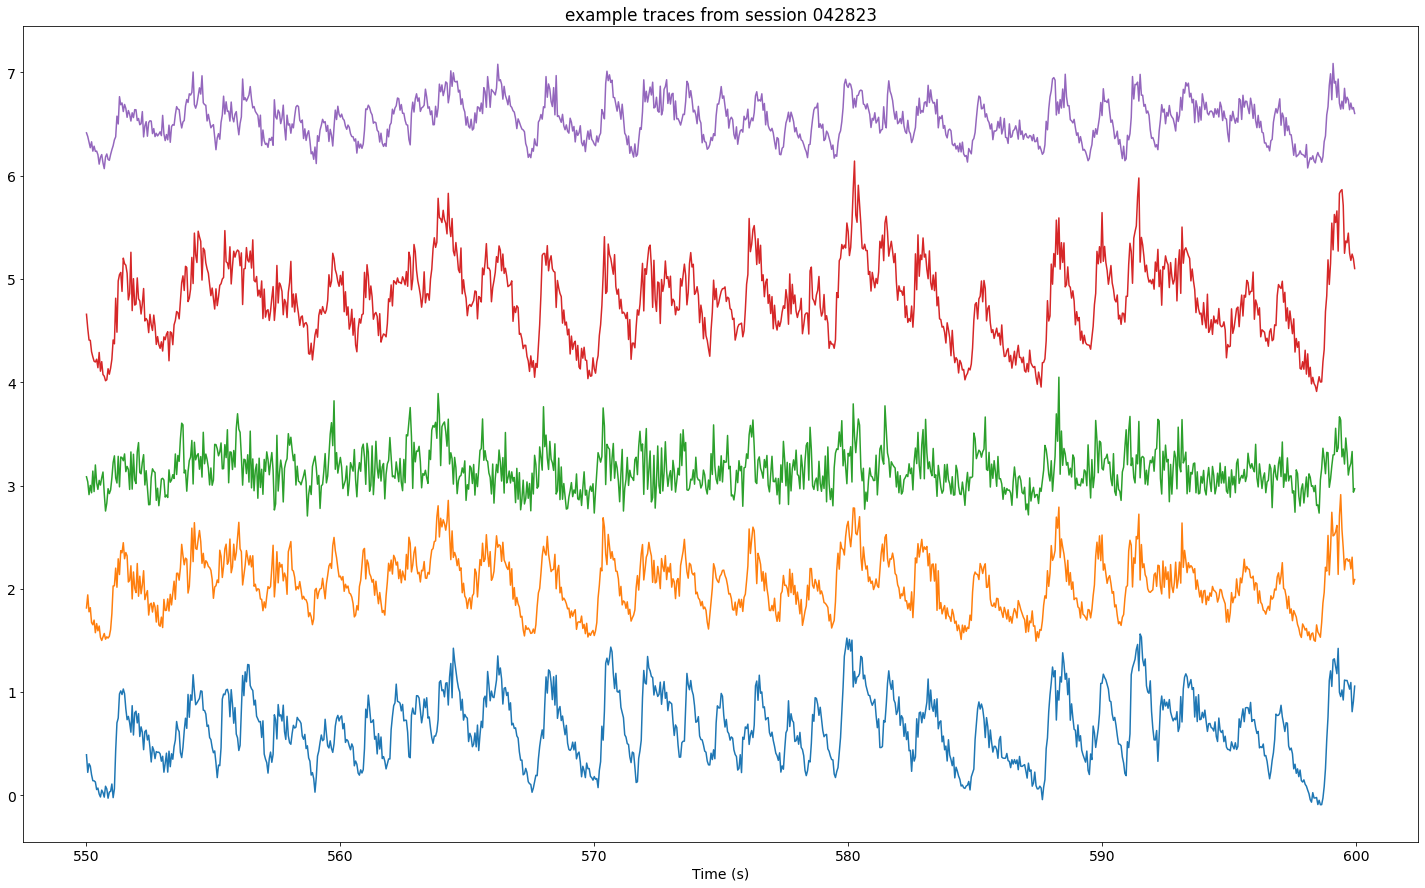

In [210]:
fig = plt.figure(figsize = [25,15])
ax = fig.add_subplot()

session = sessions[3]

start_idx = 11000
end_idx =12000
time_trace = np.arange(start_idx,end_idx)/20

dff_now = data_dict[session]['dff_sessionwise'][needed_rois,:]
dff_now = dff_now*pixnum_list[:,np.newaxis]
offset = 0
for group_i in np.arange(optimal_k):
    cell_indices_needed =kmeans.labels_ == group_i 
    dff_group = np.nanmean(dff_now[cell_indices_needed,:],0)/np.mean(pixnum_list[cell_indices_needed])
    dff_group = dff_group[start_idx:end_idx]
    ax.plot(time_trace,dff_group+offset)
    #ax.text(time_trace[0],offset,'group {}'.format(group_i))
    offset += np.nanmax(dff_group)
#ax.yaxis.set_visible(False)
ax.set_title('example traces from session {}'.format(session))
ax.set_xlabel('Time (s)')

In [79]:
# fields_to_add = ['F_sessionwise',
#                  'dff_sessionwise',
#                  'F0',
#                  'mean_image',
#                  'go_cue_times',
#                  'lick_times',
#                  'reward_times',
#                  'trial_times',
#                  'reward_collecting_lick_times',
#                  'sampling_rate',
#                  'all_si_filenames',
#                  'all_si_frame_nums',
#                  'scanimage_filenames']


# for subject in np.unique(subjects):
#     fovs = []
#     for session in sessions:
#         if subject == data_dict[session]['subject']:
#             fovs.append(data_dict[session]['FOV'])
#     for FOV in np.unique(fovs):
#         expname = '{}_{}'.format(subject,FOV)
#         data_dict[expname] = {}
#         data_dict[expname]['stat'] = np.load(os.path.join(s2p_base_dir,subject,fov,'stat.npy'),allow_pickle=True).tolist()
#         for field in fields_to_add:
#             data_dict[expname][field] = []

#         for session in sessions:
#             if not (subject == data_dict[session]['subject'] and  FOV == data_dict[session]['FOV']):
#                 continue
#             for field in fields_to_add:
#                 data_dict[expname][field].append(data_dict[session][field])
#         for field in fields_to_add:
#             try:
#                 data_dict[expname][field] = np.concatenate(data_dict[expname][field],1)
#             except:
#                 try:
#                     data_dict[expname][field] = np.concatenate(data_dict[expname][field],0)
#                 except:
#                     print(field)
            
                




In [100]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)


In [6]:
step_back = 60
step_forward = 120
time_vector = np.arange(-step_back,step_forward)/20
dff_go_cue_locked = []
dff_reward_locked = []
dff_reward_lick_locked = []
for session in sessions:
    dff_now = data_dict[session]['dff_sessionwise'][needed_rois,:]
    
    dff_now = dff_now*pixnum_list[:,np.newaxis]/np.mean(pixnum_list)
    dff_go_cue_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                    data_dict[session]['all_si_filenames'],
                                                    data_dict[session]['scanimage_filenames'],
                                                    data_dict[session]['all_si_frame_nums'],
                                                    data_dict[session]['sampling_rate'],
                                                    'go_cue',
                                                    data_dict[session]['go_cue_times'],
                                                    data_dict[session]['reward_times'],
                                                    max_frames=None,
                                                    frames_after=step_forward,
                                                    frames_before=step_back)
    dff_reward_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                    data_dict[session]['all_si_filenames'],
                                                    data_dict[session]['scanimage_filenames'],
                                                    data_dict[session]['all_si_frame_nums'],
                                                    data_dict[session]['sampling_rate'],
                                                    'reward',
                                                    data_dict[session]['go_cue_times'],
                                                    data_dict[session]['reward_times'],
                                                    max_frames=None,
                                                    frames_after=step_forward,
                                                    frames_before=step_back)
    dff_reward_lick_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                    data_dict[session]['all_si_filenames'],
                                                    data_dict[session]['scanimage_filenames'],
                                                    data_dict[session]['all_si_frame_nums'],
                                                    data_dict[session]['sampling_rate'],
                                                    'reward',
                                                    data_dict[session]['go_cue_times'],
                                                    np.asarray(data_dict[session]['reward_collecting_lick_times']),
                                                    max_frames=None,
                                                    frames_after=step_forward,
                                                    frames_before=step_back)
    dff_go_cue_locked.append(dff_go_cue_locked_)
    dff_reward_locked.append(dff_reward_locked_)
    dff_reward_lick_locked.append(dff_reward_lick_locked_)

dff_go_cue_locked = np.concatenate(dff_go_cue_locked,2)
dff_reward_locked = np.concatenate(dff_reward_locked,2)
dff_reward_lick_locked = np.concatenate(dff_reward_lick_locked,2)


In [82]:
# import matplotlib.pyplot as plt
# from rastermap import Rastermap
# minimum_f0 = 2#5#3
# session = sessions[0]




# needed_rois = np.mean(data_dict[session]['F0'],1)>=minimum_f0
# dff_now = data_dict[session]['dff_sessionwise'][needed_rois,:]





# stat_now = np.asarray(stat)[needed_rois]
# model = Rastermap(n_components=2, n_X=10, nPC=20, init='pca')
# model.fit(dff_now)


# fig = plt.figure(figsize = [10,15])
# ax1 = fig.add_subplot(2,1,1)
# ax2 = fig.add_subplot(2,1,2)
# im = ax1.imshow(dff_now,aspect='auto')
# im.set_clim([-.1,10])
# ax1.set_xlabel('Time (frames @ 20 Hz)')
# ax1.set_ylabel('ROIs')
# im = ax2.imshow(dff_now[model.isort, :],aspect = 'auto')
# im.set_clim([-.1,10])
# ax1.set_title('{}_{}'.format(data_dict[session]['mouse'],session))
# #ax2.hlines(group_edges,0,dff_now.shape[1]-1,'red')
# ax2.set_xlabel('Time (frames @ 20 Hz)')
# ax2.set_ylabel('ROIs')
# ax2.set_title('{}_{}'.format(data_dict[session]['mouse'],session))

In [83]:
# step_back = 40
# step_forward = 120
# time_vector = np.arange(-step_back,step_forward)/20
# dff_go_cue_locked = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
#                                                 data_dict[session]['all_si_filenames'],
#                                                 data_dict[session]['scanimage_filenames'],
#                                                 data_dict[session]['all_si_frame_nums'],
#                                                 20,
#                                                 'go_cue',
#                                                 data_dict[session]['go_cue_times'],
#                                                 data_dict[session]['reward_times'],
#                                                 max_frames=None,
#                                                 frames_after=step_forward,
#                                                 frames_before=step_back)
# dff_reward_locked = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
#                                                 data_dict[session]['all_si_filenames'],
#                                                 data_dict[session]['scanimage_filenames'],
#                                                 data_dict[session]['all_si_frame_nums'],
#                                                 20,
#                                                 'reward',
#                                                 data_dict[session]['go_cue_times'],
#                                                 data_dict[session]['reward_times'],
#                                                 max_frames=None,
#                                                 frames_after=step_forward,
#                                                 frames_before=step_back)
# dff_reward_lick_locked = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
#                                                 data_dict[session]['all_si_filenames'],
#                                                 data_dict[session]['scanimage_filenames'],
#                                                 data_dict[session]['all_si_frame_nums'],
#                                                 20,
#                                                 'reward',
#                                                 data_dict[session]['go_cue_times'],
#                                                 np.asarray(data_dict[session]['reward_collecting_lick_times']),
#                                                 max_frames=None,
#                                                 frames_after=step_forward,
#                                                 frames_before=step_back)

In [84]:
# import scipy
# cross_corr_matrix = np.zeros([sum(needed_rois)]*2)
# for i,trace1 in enumerate(dff_now[model.isort,:]):
#     for ii,trace2 in enumerate(dff_now[model.isort,:]):
#         cross_corr_matrix[i,ii], pearsons_p = scipy.stats.pearsonr(trace1,trace2)


In [85]:
# #group_edges = [0,55,99,115,134,146]

# fig = plt.figure(figsize  = [15,15])
# ax_corr_matrix = fig.add_subplot(1,1,1)
# ax_corr_matrix.imshow(cross_corr_matrix)
# #ax_corr_matrix.vlines(group_edges,0,cross_corr_matrix.shape[0]-1,'red')
# #ax_corr_matrix.hlines(group_edges,0,cross_corr_matrix.shape[0]-1,'red')
# ax_corr_matrix.set_xlabel('ROIs')
# ax_corr_matrix.set_ylabel('ROIs')
# ax_corr_matrix.set_title('Cross_correlation')


In [86]:
dff_go_cue_locked.shape

(180, 445, 865)

/tmp/ipykernel_6280/2937595502.py:8: RuntimeWarning: Mean of empty slice
  reward_traces_now = np.nanmean(dff_go_cue_locked[:,cell_indices_needed,:],1).squeeze()
/tmp/ipykernel_6280/2937595502.py:34: RuntimeWarning: Mean of empty slice
  reward_traces_now = np.nanmean(dff_reward_lick_locked[:,cell_indices_needed,:],1).squeeze()


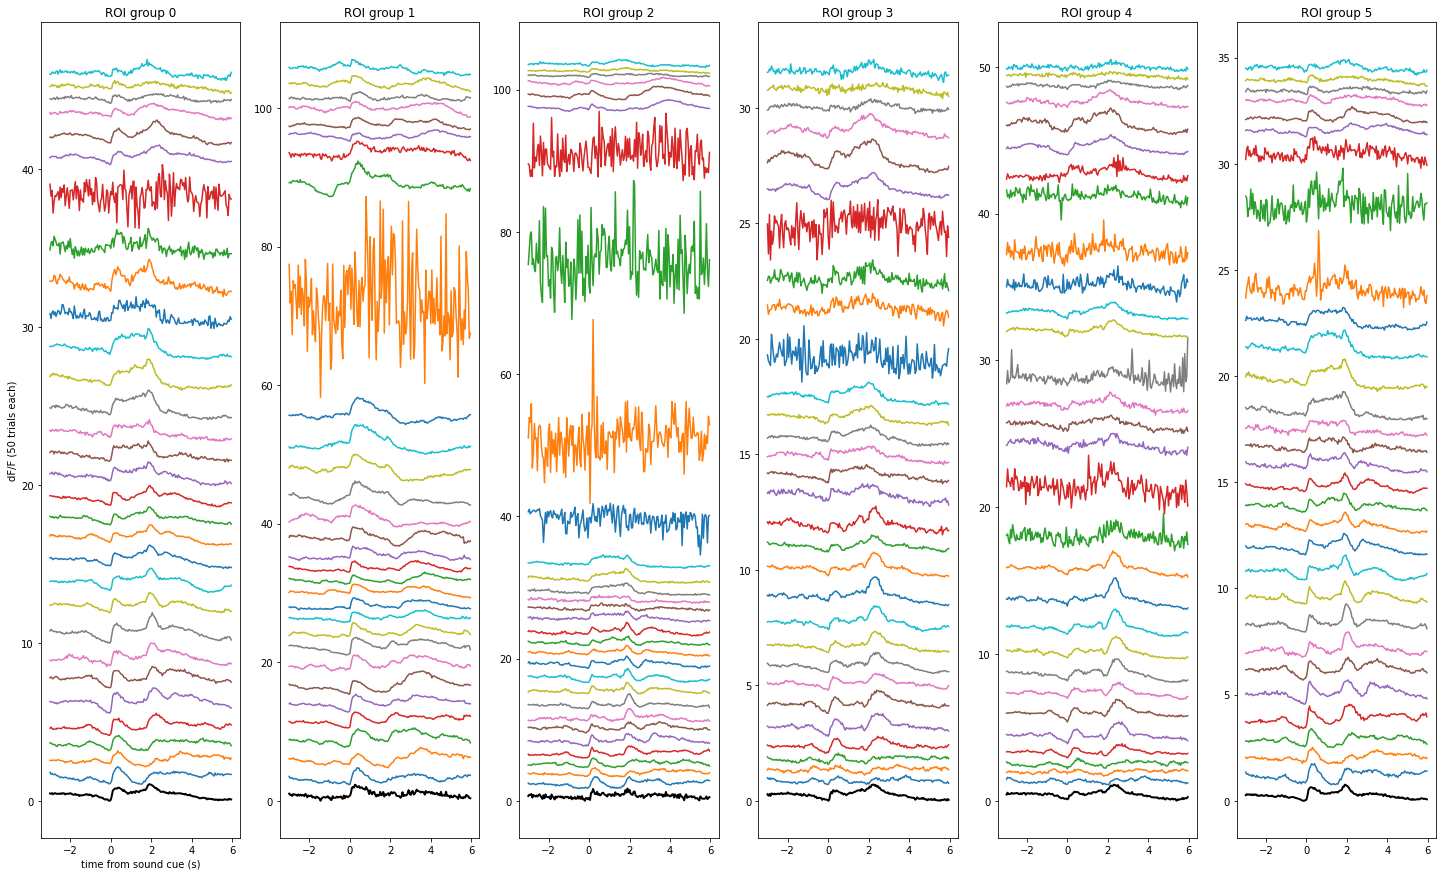

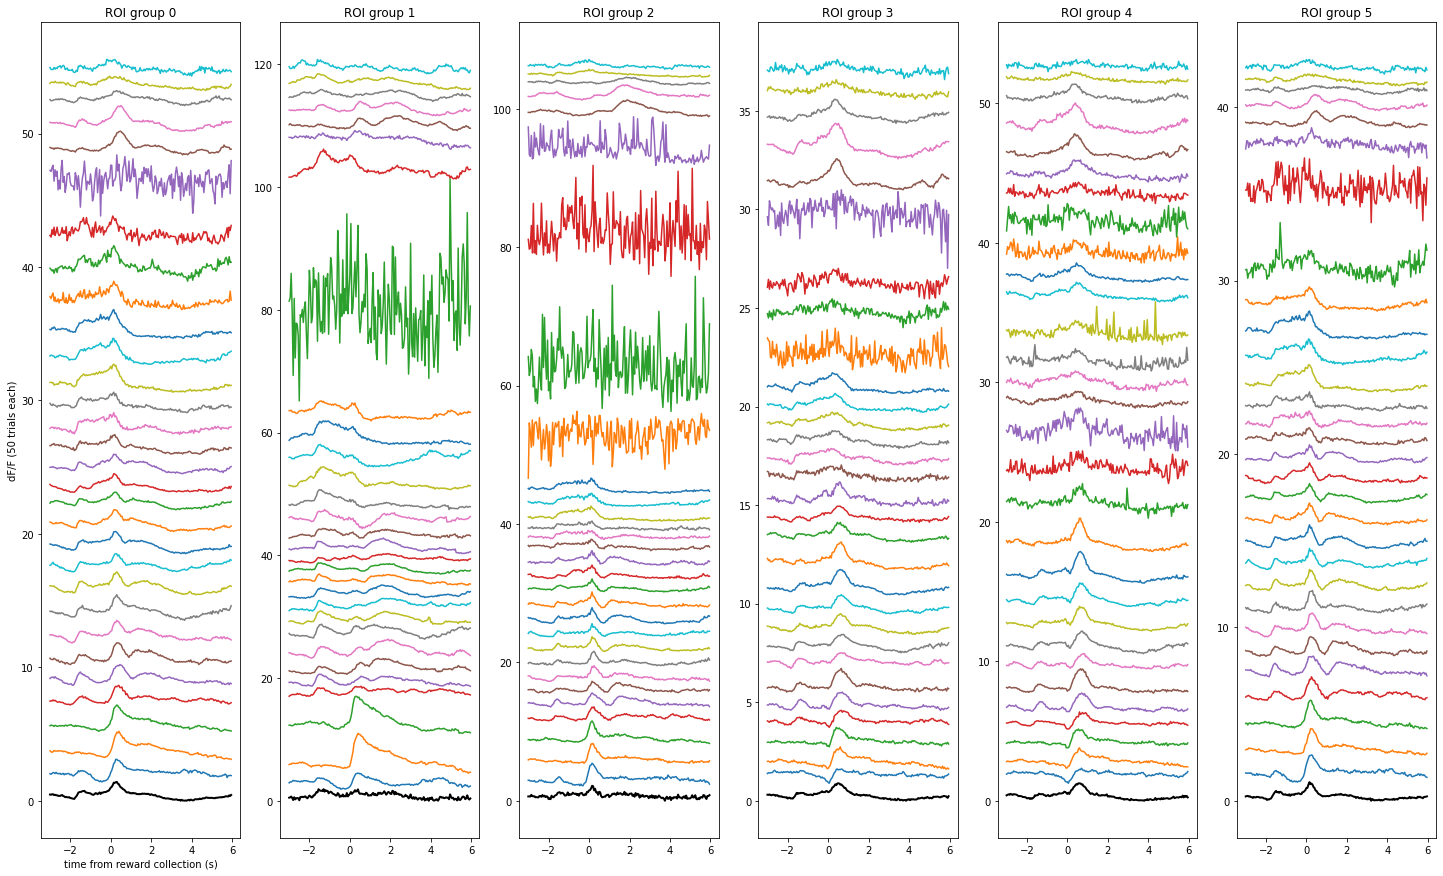

In [7]:
trial_window = 50
fig = plt.figure(figsize = [25,15])
#fig_all_traces = 
for group_i in np.arange(optimal_k):
    ax_now = fig .add_subplot(1,optimal_k,group_i+1)
    ax_now.set_title('ROI group {}'.format(group_i))
    cell_indices_needed  =kmeans.labels_ == group_i 
    reward_traces_now = np.nanmean(dff_go_cue_locked[:,cell_indices_needed,:],1).squeeze()
    
    offset = 0
    trace_now = np.nanmean(reward_traces_now,1)
    trace_now = trace_now-np.nanmin(trace_now)
    ax_now.plot(time_vector,trace_now+offset,'k-',linewidth = 2)
    offset += np.nanmax(trace_now)
    for trial_start in np.arange(0,dff_go_cue_locked.shape[2],trial_window):
        trial_end  = trial_start + trial_window
        trace_now = np.nanmean(reward_traces_now[:,trial_start:trial_end],1)
        trace_now = trace_now-np.nanmin(trace_now)
        ax_now.plot(time_vector,trace_now+offset)
        offset += np.nanmax(trace_now)
    if group_i == 0:
        ax_now.set_xlabel('time from sound cue (s)')
        ax_now.set_ylabel('dF/F ({} trials each)'.format(trial_window))
    

    
    

fig = plt.figure(figsize = [25,15])
for group_i in np.arange(optimal_k):
    ax_now = fig .add_subplot(1,optimal_k,group_i+1)
    ax_now.set_title('ROI group {}'.format(group_i))
    cell_indices_needed =kmeans.labels_ == group_i 
    reward_traces_now = np.nanmean(dff_reward_lick_locked[:,cell_indices_needed,:],1).squeeze()
    offset = 0
    trace_now = np.nanmean(reward_traces_now,1)
    trace_now = trace_now-np.nanmin(trace_now)
    ax_now.plot(time_vector,trace_now+offset,'k-',linewidth = 2)
    offset += np.nanmax(trace_now)
    for trial_start in np.arange(0,dff_reward_lick_locked.shape[2],trial_window):
        trial_end  = trial_start + trial_window
        trace_now = np.nanmean(reward_traces_now[:,trial_start:trial_end],1)
        trace_now = trace_now-np.nanmin(trace_now)
        ax_now.plot(time_vector,trace_now+offset)
        offset += np.nanmax(trace_now)
    if group_i == 0:
        ax_now.set_xlabel('time from reward collection (s)')
        ax_now.set_ylabel('dF/F ({} trials each)'.format(trial_window))
        
        

In [252]:
nonrigid_X_offset_list.T[:,x_start:x_end]

array([[-2.        ,  0.        ,  0.5       , ..., -2.        ,
         2.2       ,  0.79999995],
       [-1.1000001 , -0.5999999 , -0.7       , ...,  0.10000002,
         0.8000001 ,  0.0999999 ],
       [-0.5999999 , -0.4000001 , -0.29999995, ...,  0.6       ,
         0.70000005, -0.30000007],
       ...,
       [-1.3999999 ,  0.29999995, -0.10000014, ...,  1.5999999 ,
         0.        ,  0.4000001 ],
       [-0.79999995,  0.79999995, -1.        , ...,  1.3000001 ,
         0.0999999 ,  0.5       ],
       [-0.79999995, -0.6       ,  0.39999998, ...,  1.6       ,
        -0.39999998,  0.6       ]], dtype=float32)

array([ 29846,  64548, 101552, 142852, 179135, 219737, 257332, 293864,
       326558])

In [271]:
sessions

['042423',
 '042523',
 '042623',
 '042723',
 '042823',
 '050123',
 '050223',
 '050323',
 '050423']

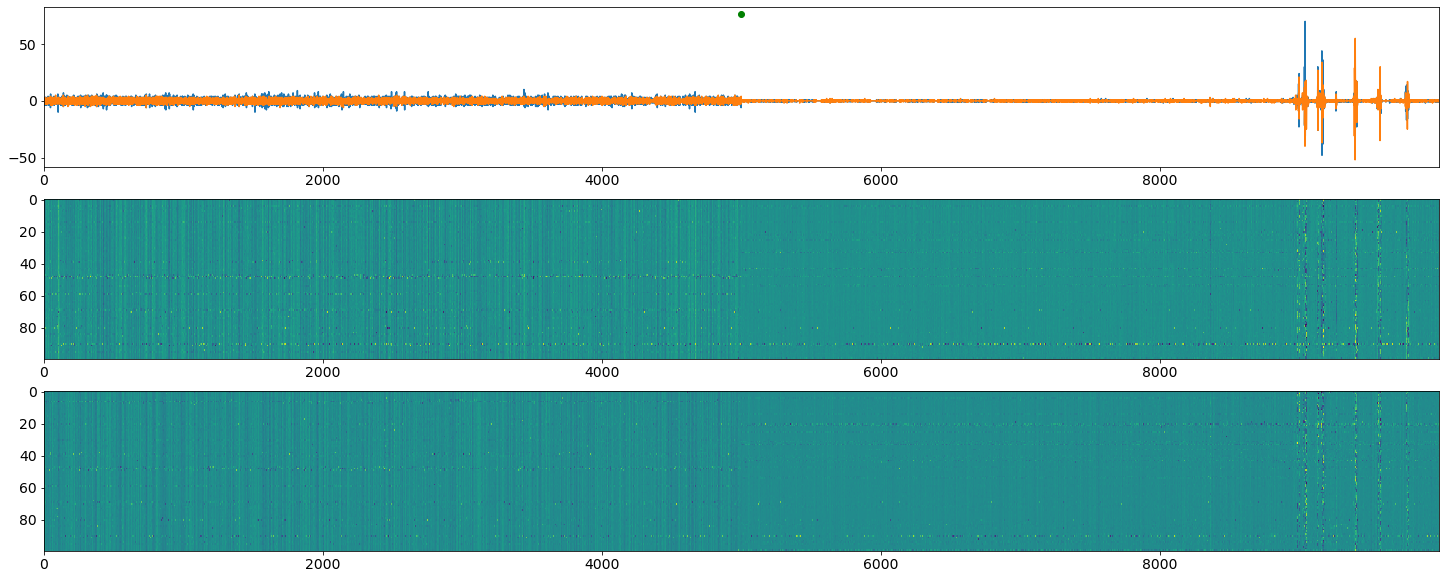

In [272]:
x_start = 0#30000
x_end = -1#31000

# x_start = 300000
# x_end = 350000

X_offset_list= []
Y_offset_list = []
nonrigid_X_offset_list= []
nonrigid_Y_offset_list = []
session_lens = []
for session in sessions:
    X_offset_list.append(data_dict[session]['rigid_x_offset'])
    Y_offset_list.append(data_dict[session]['rigid_y_offset'])
    nonrigid_X_offset_list.append(data_dict[session]['nonrigid_x_offset'])
    nonrigid_Y_offset_list.append(data_dict[session]['nonrigid_y_offset'])
    session_lens.append(len(data_dict[session]['rigid_x_offset']))
session_ends = np.cumsum(session_lens)
x_start = session_ends[-2]-5000
x_end = session_ends[-2]+5000
X_offset_list = np.concatenate(X_offset_list)
Y_offset_list = np.concatenate(Y_offset_list,0)
nonrigid_Y_offset_list = np.concatenate(nonrigid_Y_offset_list)
nonrigid_X_offset_list = np.concatenate(nonrigid_X_offset_list,0)


X_offset_list = np.diff(X_offset_list)
Y_offset_list = np.diff(Y_offset_list)
nonrigid_Y_offset_list =np.diff(nonrigid_Y_offset_list,axis = 0)
nonrigid_X_offset_list =np.diff(nonrigid_X_offset_list,axis = 0)

fig = plt.figure(figsize = [25,10])
ax1= fig.add_subplot(3,1,1)
ax1.plot(X_offset_list[x_start:x_end])
ax1.plot(Y_offset_list[x_start:x_end])
if x_end == -1:
    x_end = len(nonrigid_Y_offset_list)
needed_session_end = (session_ends>=x_start) & (session_ends<=x_end)
session_ends = session_ends[needed_session_end] - x_start
ylimits = ax1.get_ylim()
ax1.plot(session_ends,np.ones(len(session_ends))*ylimits[1],'go')

ax2= fig.add_subplot(3,1,2,sharex = ax1)
im_x = ax2.imshow(nonrigid_X_offset_list.T[:,x_start:x_end],aspect = 'auto',interpolation = 'none')
ax3= fig.add_subplot(3,1,3,sharex = ax1)
im_y = ax3.imshow(nonrigid_Y_offset_list.T[:,x_start:x_end],aspect = 'auto',interpolation = 'none')

#ax1.set_xlim()

In [ ]:
# cut out XYZ and nonrigid movements


step_back = 60
step_forward = 120
time_vector = np.arange(-step_back,step_forward)/20
dff_go_cue_locked = []
dff_reward_locked = []
dff_reward_lick_locked = []
for session in sessions:
    dff_now = data_dict[session]['dff_sessionwise'][needed_rois,:]
    
    dff_now = dff_now*pixnum_list[:,np.newaxis]/np.mean(pixnum_list)
    dff_go_cue_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                    data_dict[session]['all_si_filenames'],
                                                    data_dict[session]['scanimage_filenames'],
                                                    data_dict[session]['all_si_frame_nums'],
                                                    20,
                                                    'go_cue',
                                                    data_dict[session]['go_cue_times'],
                                                    data_dict[session]['reward_times'],
                                                    max_frames=None,
                                                    frames_after=step_forward,
                                                    frames_before=step_back)
    dff_reward_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                    data_dict[session]['all_si_filenames'],
                                                    data_dict[session]['scanimage_filenames'],
                                                    data_dict[session]['all_si_frame_nums'],
                                                    20,
                                                    'reward',
                                                    data_dict[session]['go_cue_times'],
                                                    data_dict[session]['reward_times'],
                                                    max_frames=None,
                                                    frames_after=step_forward,
                                                    frames_before=step_back)
    dff_reward_lick_locked_ = BCI_analysis.io_suite2p.sessionwise_to_trialwise(dff_now,
                                                    data_dict[session]['all_si_filenames'],
                                                    data_dict[session]['scanimage_filenames'],
                                                    data_dict[session]['all_si_frame_nums'],
                                                    20,
                                                    'reward',
                                                    data_dict[session]['go_cue_times'],
                                                    np.asarray(data_dict[session]['reward_collecting_lick_times']),
                                                    max_frames=None,
                                                    frames_after=step_forward,
                                                    frames_before=step_back)
    dff_go_cue_locked.append(dff_go_cue_locked_)
    dff_reward_locked.append(dff_reward_locked_)
    dff_reward_lick_locked.append(dff_reward_lick_locked_)

dff_go_cue_locked = np.concatenate(dff_go_cue_locked,2)
dff_reward_locked = np.concatenate(dff_reward_locked,2)
dff_reward_lick_locked = np.concatenate(dff_reward_lick_locked,2)